In [1]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime, timedelta
from prometheus_api_client.utils import parse_datetime
from prometheus_api_client import PrometheusConnect

In [2]:
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax

In [3]:
path = "../../Result_json/"
file_list = os.listdir(path)
airflow_files = [file for file in file_list if file.startswith("airflow")]
airbyte_files = [file for file in file_list if file.startswith("normalized_airbyte")]
unnorm_files = [file for file in file_list if file.startswith("airbyte")]
# Sort list
airflow_files = sorted(airflow_files)
airbyte_files = sorted(airbyte_files)
unnorm_airbyte = sorted(unnorm_files)

print(airflow_files, airbyte_files, unnorm_files, sep='\n')

['airflow_populate_source.txt', 'airflow_populate_target.txt', 'airflow_status.txt']
['normalized_airbyte_populate_source.txt', 'normalized_airbyte_populate_target.txt', 'normalized_airbyte_status.txt']
['airbyte_populate_source.txt', 'airbyte_populate_target.txt', 'airbyte_status.txt']


In [4]:
source, target, status = [], [], []
for file, lst in zip(airflow_files, [source, target, status]):
    with open(path + file) as f:
        for line in f:
            temp_json = json.loads(line)
            temp_json['framework'] = "Airflow + Spark"
            lst.append(temp_json)
            
for file, lst in zip(airbyte_files, [source, target]):
    with open(path + file) as f:
        for line in f:
            temp_json = json.loads(line)
            temp_json['framework'] = "Airbyte"
            lst.append(temp_json)        
            
            
status_airbyte = []
with open(path + airbyte_files[-1]) as f:
    for line in f:
        temp_json = json.loads(line)
        temp_json['framework'] = "Airbyte"
        status_airbyte.append(temp_json)                     

In [5]:
source = pd.DataFrame.from_dict(source, orient='columns').explode(["tables_names", "rows_count", "total_size_bytes"]).reset_index(drop=True)
target = pd.DataFrame.from_dict(target, orient='columns').explode(["tables_names", "rows_count", "total_size_bytes"]).reset_index(drop=True)
status = pd.DataFrame.from_dict(status, orient='columns')
status_airbyte = pd.DataFrame.from_dict(status_airbyte, orient='columns')

display(source.head(3))
display(target.head(3))
display(status.head(3))
display(status_airbyte.head(3))

,benchmark_id,operation,start_time,end_time,sf,tables_names,rows_count,total_size_bytes,framework
0,MjAyMzExMDgxMjM3NDQ=,populate_db,1.699447e+09,1.699447e+09,3,cashtransaction,361856,41091072,Airflow + Spark
1,MjAyMzExMDgxMjM3NDQ=,populate_db,1.699447e+09,1.699447e+09,3,dailymarket,1282768,98697216,Airflow + Spark
2,MjAyMzExMDgxMjM3NDQ=,populate_db,1.699447e+09,1.699447e+09,3,date,25933,7340032,Airflow + Spark


,benchmark_id,sf,tables_names,rows_count,total_size_bytes,framework
0,MjAyMzExMDgxMjM3NDQ=,3,cashtransaction,361856,40615936,Airflow + Spark
1,MjAyMzExMDgxMjM3NDQ=,3,dailymarket,1282768,98213888,Airflow + Spark
2,MjAyMzExMDgxMjM3NDQ=,3,date,25933,6856704,Airflow + Spark


,benchmark_id,startTime,endTime,TimeDelta,operation,framework
0,MjAyMzExMDgxMjM3NDQ=,2023-11-08T12:38:07.590649+00:00,2023-11-08T12:39:14.198780+00:00,66.61,sync_airflow,Airflow + Spark
1,MjAyMzExMDgxMjM5MTU=,2023-11-08T12:39:41.551226+00:00,2023-11-08T12:41:04.374189+00:00,82.82,sync_airflow,Airflow + Spark
2,MjAyMzExMDgxMjQxMDk=,2023-11-08T12:41:40.638150+00:00,2023-11-08T12:43:19.428467+00:00,98.79,sync_airflow,Airflow + Spark


,jobId,jobType,startTime,bytesSynced,rowsSynced,TimeDelta,Throughput,operation,benchmark_id,framework
0,123,sync,2023-11-07 13:58:54,6.107011e+08,4525390.0,192,23569.74,sync_airbyte,MjAyMzExMDcxMzU4MjA=,Airbyte
1,125,sync,2023-11-07 14:02:49,8.317040e+08,6160471.0,252,24446.31,sync_airbyte,MjAyMzExMDcxNDAyMDk=,Airbyte
2,127,sync,2023-11-07 14:07:47,1.043358e+09,7779939.0,327,23791.86,sync_airbyte,MjAyMzExMDcxNDA3MDU=,Airbyte


In [6]:
# Source Fix types
source.rows_count = source.rows_count.astype(int)
source.total_size_bytes = source.total_size_bytes.astype(np.int64)
source.start_time = pd.to_datetime(source.start_time, unit='s')
source.end_time = pd.to_datetime(source.end_time, unit='s')
# Target Fix types
target.rows_count = target.rows_count.astype(int)
target.total_size_bytes = target.total_size_bytes.astype(np.int64)
# Status fix types
status.startTime = pd.to_datetime(status.startTime.str.replace("+00:00", ""), format="%Y-%m-%dT%H:%M:%S.%f")
status.endTime = pd.to_datetime(status.endTime.str.replace("+00:00", ""), format="%Y-%m-%dT%H:%M:%S.%f")
# status_airbyte fix types
status_airbyte.startTime = pd.to_datetime(status_airbyte.startTime, format="%Y-%m-%d %H:%M:%S")

# Source create time_delta
source["time_delta"] = (source.end_time - source.start_time).dt.total_seconds()


In [7]:
source_grouped = source.groupby(["framework", "benchmark_id", "sf"]).agg({"rows_count": "sum", "total_size_bytes": "sum", "time_delta": "max"}).reset_index()
target_grouped = target.groupby(["framework", "benchmark_id", "sf"]).agg({"rows_count": "sum", "total_size_bytes": "sum"}).reset_index()

# join source and status
target_status = target[["framework", "benchmark_id", "sf"]].merge(status, left_on=["framework", "benchmark_id"], right_on=["framework", "benchmark_id"], how="inner")
target_status = target_status.groupby(["framework", "benchmark_id", "sf"]).TimeDelta.max().reset_index()
# join source and status aibyte
target_status_airbyte = target[["framework", "benchmark_id", "sf"]].merge(status_airbyte, left_on=["framework", "benchmark_id"], right_on=["framework", "benchmark_id"], how="inner")
target_status_airbyte = target_status_airbyte.groupby(["framework", "benchmark_id", "sf"]).TimeDelta.max().reset_index()

source_status_combined = pd.concat([target_status, target_status_airbyte])

# Calculate Aiflow + Spark Throughput
temp_join = target_status.merge(target_grouped, left_on=["framework", "benchmark_id", "sf"], right_on=["framework", "benchmark_id", "sf"], how="inner")
temp_join["Throughput"] = temp_join.rows_count / temp_join.TimeDelta
temp_join = temp_join[['framework', 'benchmark_id' , "sf", 'TimeDelta', 'Throughput']]

# target_grouped
df_throughput = status_airbyte[['benchmark_id', 'TimeDelta', 'framework']].merge(target_grouped, left_on=["framework", "benchmark_id"], right_on=["framework", "benchmark_id"], how="inner")
df_throughput['Throughput'] = df_throughput.rows_count / df_throughput.TimeDelta
df_throughput = pd.concat([temp_join, df_throughput])

display(source_grouped.head(3))
display(target_status.head(3))

,framework,benchmark_id,sf,rows_count,total_size_bytes,time_delta
0,Airbyte,MjAyMzExMDcxMzU4MjA=,3,4525390,413368320,17.896000
1,Airbyte,MjAyMzExMDcxNDA3MDU=,5,7779939,704872448,25.865250
2,Airbyte,MjAyMzExMDcxNDAyMDk=,4,6160471,562806784,23.860181


,framework,benchmark_id,sf,TimeDelta
0,Airflow + Spark,MjAyMzExMDgxMjM3NDQ=,3,66.61
1,Airflow + Spark,MjAyMzExMDgxMjM5MTU=,4,82.82
2,Airflow + Spark,MjAyMzExMDgxMjQ1NTk=,7,130.50


In [8]:
mask = source_grouped.framework == "Airbyte"
# Transform in dictionary, sf as key, total_size_bytes as value
temp = source_grouped.loc[mask, ["sf", "total_size_bytes"]]
temp.total_size_bytes = temp.total_size_bytes.astype(float)
temp.sf = temp.sf.astype(int)
temp.total_size_bytes = temp.total_size_bytes.apply(lambda x: round(x/ 1024 / 1024 /1024, 1))
temp.sort_values(by="sf", inplace=True)
x_tick_labels = [ str(x)+"GB" for x in temp.total_size_bytes.to_list()]
print(x_tick_labels)

['0.4GB', '0.5GB', '0.7GB', '0.8GB', '0.9GB', '1.1GB', '1.3GB', '1.6GB', '1.9GB', '2.3GB', '2.7GB', '3.2GB', '3.9GB', '4.7GB', '5.6GB', '6.7GB', '8.1GB', '9.7GB']


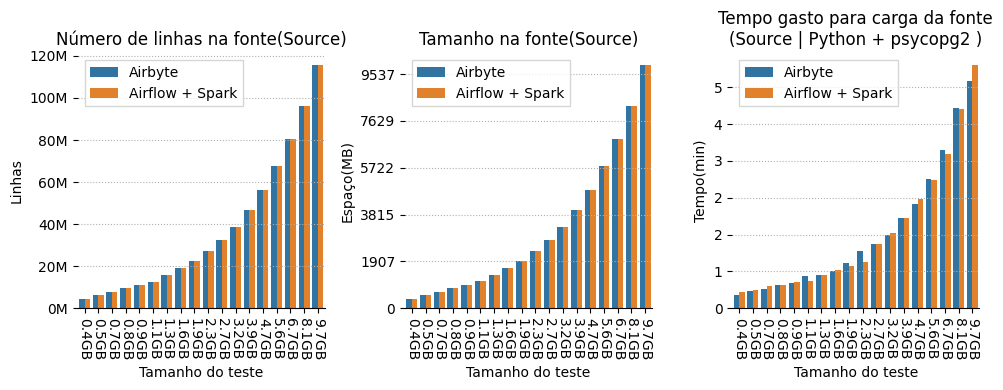

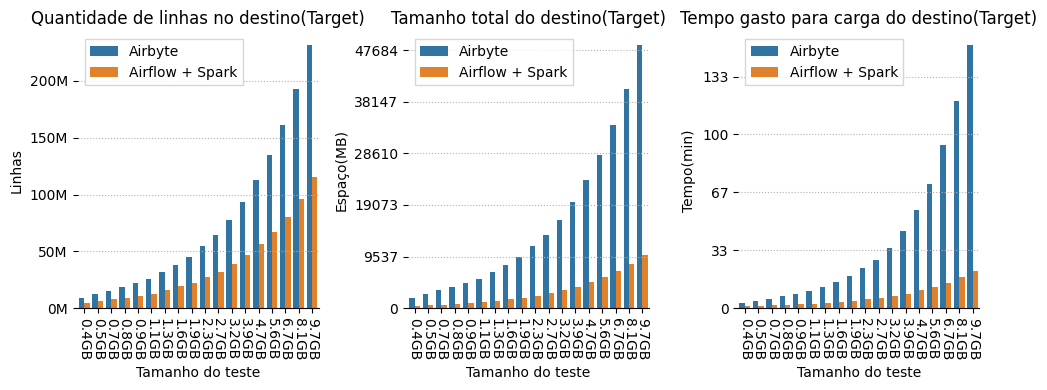

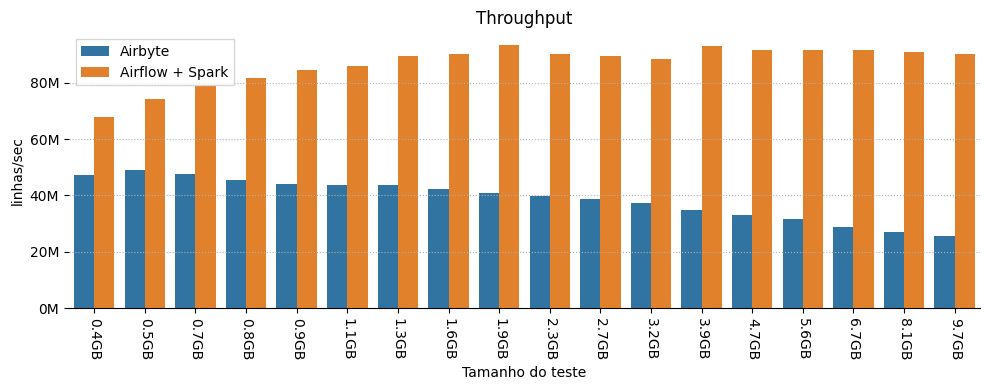

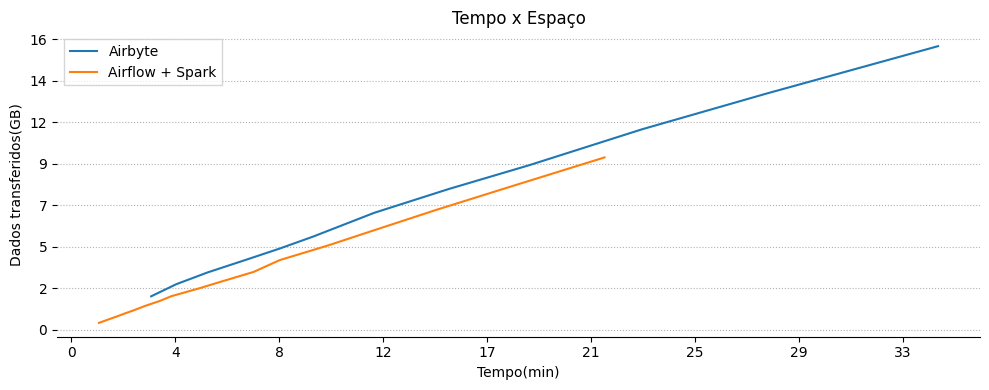

In [9]:
fg_size = (10, 4)
fig, ax = plt.subplots(1, 3, figsize=fg_size)
mask = source_grouped.sf < 125
for idx, col in enumerate(["rows_count", "total_size_bytes", "time_delta"]):
    g = sns.barplot(x="sf", y=col, hue="framework", data=source_grouped[mask], ax=ax[idx])
    if idx == 0:
        ax[idx].yaxis.set_major_formatter(lambda x, pos: '{:.0f}'.format(x/1000000) + 'M')
        ax[idx].set(ylabel="Linhas", xlabel="Tamanho do teste", title="Número de linhas na fonte(Source)")
    elif idx == 1:
        ax[idx].yaxis.set_major_formatter(lambda x, pos: '{:.0f}'.format(x/1024/1024))
        ax[idx].set(ylabel="Espaço(MB)", xlabel="Tamanho do teste", title='Tamanho na fonte(Source)')
    else:
        ax[idx].yaxis.set_major_formatter(lambda x, pos: '{:.0f}'.format(x/60))
        ax[idx].set(ylabel="Tempo(min)", xlabel="Tamanho do teste", title="Tempo gasto para carga da fonte\n(Source | Python + psycopg2 )")
    ax[idx].set_xticks(range(len(x_tick_labels)))
    ax[idx].set_xticklabels(x_tick_labels)
    for item in g.get_xticklabels():
        item.set_rotation(270)
    ax[idx].grid(axis='y', linestyle=':')
    ax[idx].legend(fancybox=False)
sns.despine(left=True)
plt.tight_layout()
plt.savefig("Figs/f1_pre_test_data.svg")
plt.show()

fig, ax = plt.subplots(1, 3, figsize=fg_size)
mask = target_grouped.sf < 125
for idx, col in enumerate(["rows_count", "total_size_bytes"]):
    g = sns.barplot(x="sf", y=col, hue="framework", data=target_grouped[mask], ax=ax[idx])
    if idx == 0:
        ax[idx].yaxis.set_major_formatter(lambda x, pos: '{:.0f}'.format(x/1000000) + 'M')
        ax[idx].set(ylabel="Linhas", xlabel="Tamanho do teste", title="Quantidade de linhas no destino(Target)")
    else:
        ax[idx].yaxis.set_major_formatter(lambda x, pos: '{:.0f}'.format(x/1024/1024))
        ax[idx].set(ylabel="Espaço(MB)", xlabel="Tamanho do teste", title="Tamanho total do destino(Target)")
        
    ax[idx].set_xticks(range(len(x_tick_labels)))
    ax[idx].set_xticklabels(x_tick_labels)
    for item in g.get_xticklabels():
        item.set_rotation(270)
    ax[idx].grid(axis='y', linestyle=':')
    ax[idx].legend(fancybox=False)
# sns.despine(left=True)
# plt.show()

source_status_combined = source_status_combined.sort_values(by=["framework", "sf"]).reset_index(drop=True)
mask = source_status_combined.sf < 125
g = sns.barplot(x="sf", y="TimeDelta", hue="framework", data=source_status_combined[mask], ax=ax[2])
# Set y-axis scale to millions with separators
ax[2].yaxis.set_major_formatter(lambda x, pos: '{:.0f}'.format(x/60))
ax[2].set_xticks(range(len(x_tick_labels)))
ax[2].set_xticklabels(x_tick_labels)
# rotate x_tick_labels 90º
for item in g.get_xticklabels():
    item.set_rotation(270)
ax[2].set(ylabel="Tempo(min)", xlabel="Tamanho do teste", title="Tempo gasto para carga do destino(Target)")
ax[2].grid(axis='y', linestyle=':')
ax[2].legend(fancybox=False)
sns.despine(left=True)
plt.tight_layout()
plt.savefig("Figs/f2_pos_test_data.svg")
plt.show()

df_throughput = df_throughput.sort_values(by=["framework", "sf"]).reset_index(drop=True)
mask = df_throughput.sf < 125
fig, ax = plt.subplots(figsize=fg_size)
g = sns.barplot(x="sf", y="Throughput", hue="framework", data=df_throughput[mask], ax=ax)
# Set y-axis scale to millions with separators
ax.set_xticks(range(len(x_tick_labels)))
ax.set_xticklabels(x_tick_labels)
# rotate x_tick_labels 90º
for item in g.get_xticklabels():
    item.set_rotation(270)
ax.yaxis.set_major_formatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'M')
ax.set(ylabel="linhas/sec", xlabel="Tamanho do teste", title="Throughput")
ax.grid(axis='y', linestyle=':')
ax.legend(fancybox=False)
sns.despine(left=True)
plt.tight_layout()
plt.savefig("Figs/f3_throughput.svg")
plt.show()

temp_df = target_grouped.merge(source_status_combined, left_on=["framework", "benchmark_id", "sf"], right_on=["framework", "benchmark_id", "sf"], how="inner")

fig, ax = plt.subplots(figsize=fg_size)
mask = temp_df.TimeDelta < 40*60
sns.lineplot(x="TimeDelta", y="total_size_bytes", hue="framework", data=temp_df[mask], ax=ax)
# Set y-axis scale to millions with separators
ax.yaxis.set_major_formatter(lambda x, pos: '{:.0f}'.format(x/1024/1024/1024))
ax.xaxis.set_major_formatter(lambda x, pos: '{:.0f}'.format(x/60))
ax.set(ylabel="Dados transferidos(GB)", xlabel="Tempo(min)", title="Tempo x Espaço")
ax.grid(axis='y', linestyle=':')
ax.legend(fancybox=False)
sns.despine(left=True)
plt.tight_layout()
plt.savefig("Figs/f4_time_x_data.svg")
plt.show()

# Post Analisys

In [144]:
url = 'http://192.168.1.126:9090'
# Connect
prom = PrometheusConnect(url=url, disable_ssl=True)

my_metrics = [
    "node_cpu_seconds_total", # Seconds the CPUs spent in each mode
    "node_filesystem_avail_bytes", # Filesystem space available to non-root users in bytes.
    "node_filesystem_size_bytes", # Filesystem size in bytes.
    "node_memory_Buffers_bytes", # Memory information field Buffers_bytes.
    "node_memory_Cached_bytes", # Memory information field Cached_bytes.
    'node_memory_SReclaimable_bytes',
    'node_memory_MemFree_bytes',
    'node_memory_MemTotal_bytes',
    "pg_stat_database_tup_deleted",
    "pg_stat_database_tup_fetched",
    "pg_stat_database_tup_inserted",
    "pg_stat_database_tup_returned",
    "pg_stat_database_tup_updated",
    "pg_database_size_bytes"
]

In [145]:
status_fixed_time = status.copy()
status_fixed_time = status_fixed_time.merge(target_grouped, left_on=["framework", "benchmark_id"],
                                            right_on=["framework", "benchmark_id"], how="inner")

cols = ['benchmark_id', 'startTime', 'TimeDelta', "operation", "framework", "sf", "rows_count", "total_size_bytes"]
status_fixed_time = pd.concat([status_fixed_time, status_airbyte.merge(target_grouped, left_on=["framework", "benchmark_id"], right_on=["framework", "benchmark_id"], how="inner")[cols]])

mask = status_fixed_time.endTime.isnull()
status_fixed_time.loc[mask, "endTime"] = status_fixed_time.loc[mask, "startTime"] + status_fixed_time.loc[mask, "TimeDelta"].apply(lambda x: timedelta(seconds=x))
status_fixed_time.reset_index(drop=True, inplace=True)
status_fixed_time.startTime = status_fixed_time.startTime
status_fixed_time.endTime = status_fixed_time.endTime

status_fixed_time.tail(3)

,benchmark_id,startTime,endTime,TimeDelta,operation,framework,sf,rows_count,total_size_bytes
33,MjAyMzExMDcyMDEwNTY=,2023-11-07 20:15:14,2023-11-07 21:48:53,5619.0,sync_airbyte,Airbyte,50,160908902,35449126912
34,MjAyMzExMDcyMTUwMDg=,2023-11-07 21:55:49,2023-11-07 23:54:50,7141.0,sync_airbyte,Airbyte,60,192679040,42459979776
35,MjAyMzExMDcyMzU2MTc=,2023-11-08 00:02:28,2023-11-08 02:33:41,9073.0,sync_airbyte,Airbyte,72,231094320,50900983808


In [146]:
def return_metrics(query, start_time, end_time, step = "1m"):
    metric = prom.custom_query_range(
                query=query,  # this is the metric name and label config
                start_time=start_time,
                end_time=end_time,
                step=step
                )
    
    return metric
    
df_metrics = pd.DataFrame(columns=["benchmark_id", "framework", "sf", "instance", "cpu_usage", "memory_usage", 'memory_buffer', 'filesystem_size']) 
instances_list = ["Airflow + Spark", "Airbyte"]
for ins in instances_list:
    fin_ins = "|" + ins.upper() if ins == "Airbyte" else "|Airflow".upper()
    
    query_cpu = f'sum by(instance)(irate(node_cpu_seconds_total{{mode=~"user|system", instance=~"SOURCE|TARGET{fin_ins}"}}[1m])) / on(instance) group_left sum by(instance)(irate(node_cpu_seconds_total{{instance=~"SOURCE|TARGET{fin_ins}"}}[1m]))'
    query_memory = f'node_memory_MemTotal_bytes{{instance=~"SOURCE|TARGET{fin_ins}"}} - node_memory_MemFree_bytes{{instance=~"SOURCE|TARGET{fin_ins}"}} - (node_memory_Cached_bytes{{instance=~"SOURCE|TARGET{fin_ins}"}} + node_memory_Buffers_bytes{{instance=~"SOURCE|TARGET{fin_ins}"}} + node_memory_SReclaimable_bytes{{instance=~"SOURCE|TARGET{fin_ins}"}})' 
    query_buffer = f'node_memory_Cached_bytes{{instance=~"SOURCE|TARGET{fin_ins}"}} + node_memory_Buffers_bytes{{instance=~"SOURCE|TARGET{fin_ins}"}} + node_memory_SReclaimable_bytes{{instance=~"SOURCE|TARGET{fin_ins}"}}'
    query_fs_size = f'node_filesystem_size_bytes{{instance=~"SOURCE|TARGET{fin_ins}", mountpoint="/"}} - node_filesystem_avail_bytes{{instance=~"SOURCE|TARGET{fin_ins}", mountpoint="/"}}'
    
    mask = status_fixed_time.framework == ins
    print(status_fixed_time[mask].framework.unique())
    for row in status_fixed_time[mask].itertuples():
        
        test_id = row.benchmark_id
        test_sf = row.sf
        framework = row.framework
        # CPU Consume

        # t_delta = timedelta(hours=3)
        start_time = row.startTime
        end_time = row.endTime
        # print(start_time, end_time, sep=" - ")
        #start_time = datetime.strptime('2023-11-08 10:20:00.652962', '%Y-%m-%d %H:%M:%S.%f')#temp_row.startTime
        #end_time = datetime.strptime('2023-11-08 11:00:00.652962', '%Y-%m-%d %H:%M:%S.%f')#temp_row.endTime
        
        cpu_metric = return_metrics(query=query_cpu, start_time=start_time, end_time=end_time, step="1s")
        ram_used_metric = return_metrics(query=query_memory, start_time=start_time, end_time=end_time, step="1s")
        ram_buffer_metric = return_metrics(query=query_buffer, start_time=start_time, end_time=end_time, step="1s")
        fs_size = return_metrics(query=query_fs_size, start_time=start_time, end_time=end_time, step="1s")
        
        for cpu_item, memory_used_item, memory_buffer_item, fs_item in zip(cpu_metric, ram_used_metric, ram_buffer_metric, fs_size):
            cpu_instance = cpu_item['metric']['instance']
            cpu_usage = np.array(cpu_item['values'])[:,1]
            memory_used_usage = np.array(memory_used_item['values'])[:,1]
            memory_buffer_usage = np.array(memory_buffer_item['values'])[:,1]
            fs_usage = np.array(fs_item['values'])[:,1]
            
            aux_metrics = pd.Series([framework, test_id, test_sf, cpu_instance, cpu_usage, memory_used_usage, memory_buffer_usage, fs_usage],
                                    index=['framework', "benchmark_id", "sf", "instance", "cpu_usage", "memory_usage", 'memory_buffer', 'filesystem_size'], name=0).to_frame().T    
            df_metrics = pd.concat([df_metrics, aux_metrics], ignore_index=True)

['Airflow + Spark']
['Airbyte']


In [147]:
df_cpu = df_metrics[['benchmark_id', 'framework', 'sf', 'instance', 'cpu_usage']].explode("cpu_usage").reset_index(drop=True)
df_memory = df_metrics[['benchmark_id', 'framework', 'sf', 'instance', 'memory_usage']].explode("memory_usage").reset_index(drop=True)
df_buffer = df_metrics[['benchmark_id', 'framework', 'sf', 'instance', 'memory_buffer']].explode("memory_buffer").reset_index(drop=True)
df_fs = df_metrics[['benchmark_id', 'framework', 'sf', 'instance', 'filesystem_size']].explode("filesystem_size").reset_index(drop=True)

In [148]:
for idx, ii in enumerate([df_cpu, df_memory, df_buffer, df_fs]):
    cols = ii.columns
    ii.sf = ii.sf.astype(int)
    ii[cols[-1]] = ii[cols[-1]].astype(float)
    if idx == 0:
        ii[cols[-1]] = ii[cols[-1]] * 100
    elif idx == 3:
        ii[cols[-1]] = ii[cols[-1]] / 1000 / 1000 / 1000
    else:
        ii[cols[-1]] = ii[cols[-1]] / 1024 / 1024 / 1024
    
    temp = ii.melt(id_vars=["benchmark_id", "framework", "sf", 'instance'])
    temp = temp[['framework', 'sf', 'instance', 'value']]

In [10]:
# df_cpu.to_csv("../../Result_json/cpu_usage.csv", index=False)
# df_memory.to_csv("../../Result_json/memory_usage.csv", index=False)
# df_buffer.to_csv("../../Result_json/memory_buffer.csv", index=False)
# df_fs.to_csv("../../Result_json/filesystem_size.csv", index=False)

# df_cpu = pd.read_csv("../../Result_json/cpu_usage.csv")
# df_memory = pd.read_csv("../../Result_json/memory_usage.csv")
# df_buffer = pd.read_csv("../../Result_json/memory_buffer.csv")
# df_fs = pd.read_csv("../../Result_json/filesystem_size.csv")

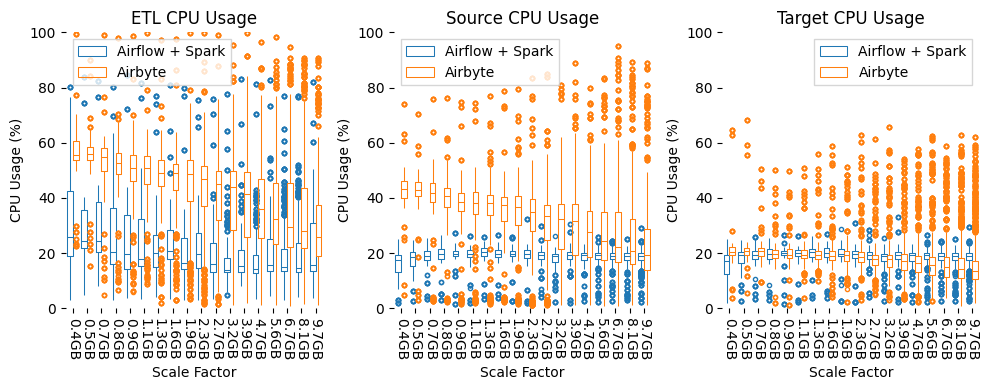

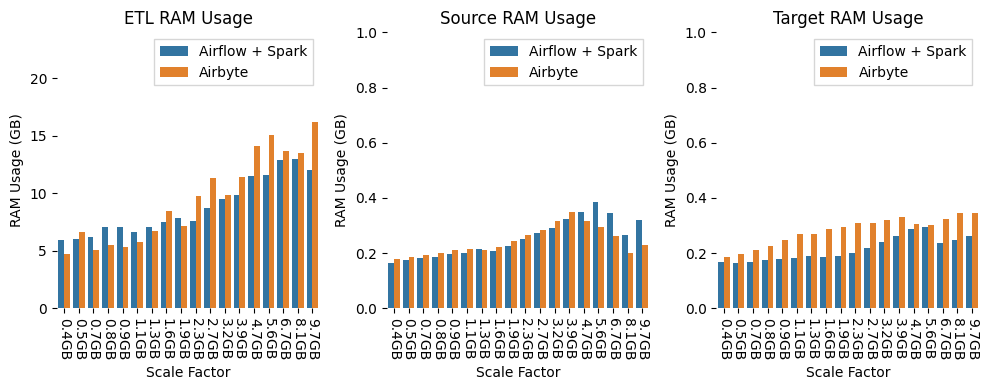

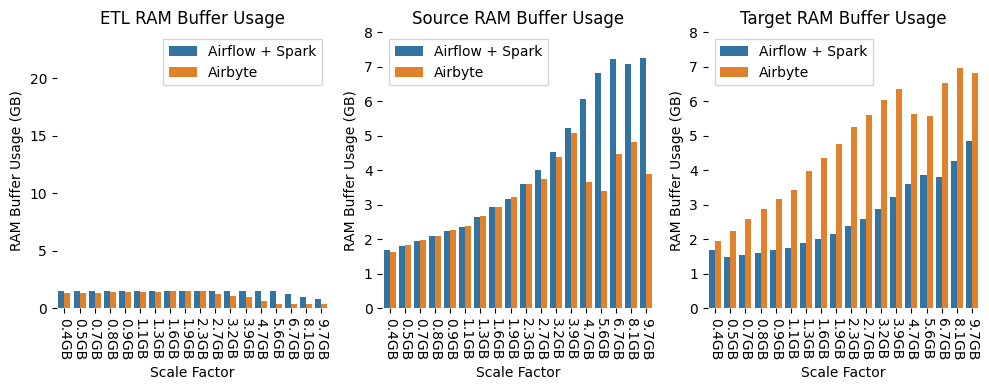

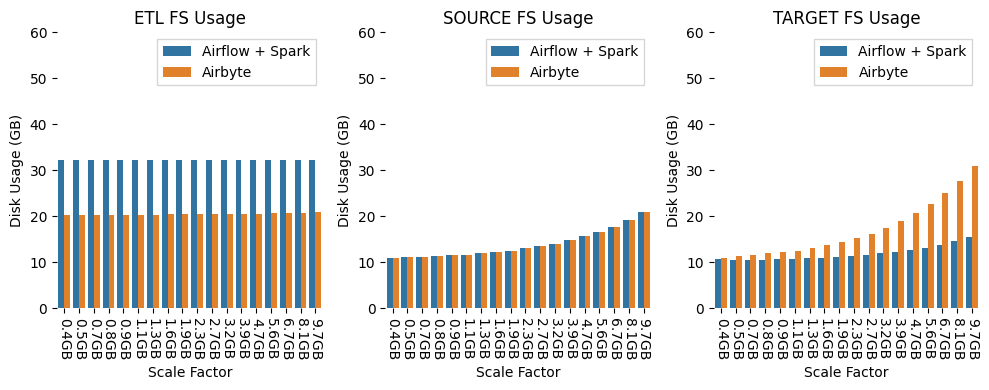

In [11]:
uni_list = [ 3,  4,  5,  6,  7,  8, 10, 12, 14, 17, 20, 24, 29, 35, 42, 50, 60, 72]#,  86, 103, 124]
resources = ["SOURCE"] * len(uni_list) + ["ETL"] * len(uni_list) + ["TARGET"] * len(uni_list)
df_result = pd.DataFrame(columns=["Resource",  "Size", "Sf", "CPU", "RAM", "BUFFER", "FS"])
df_result.Size = x_tick_labels * 3
df_result.Sf = uni_list * 3
df_result.Resource = resources

# CPU
fig, ax = plt.subplots(1, 3, figsize=fg_size)
mask = (df_cpu.instance == "AIRFLOW") | (df_cpu.instance == "AIRBYTE")
g = sns.boxplot(df_cpu[mask], x='sf', y='cpu_usage', hue='framework', ax=ax[0],
            fill=False, linewidth=.75, flierprops={"marker": "."}, showcaps=False
            ).set(ylim=(0, 100), title="ETL CPU Usage", xlabel="Scale Factor",
             ylabel="CPU Usage (%)", xticks=range(len(x_tick_labels)), xticklabels=x_tick_labels)
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=270)
ax[0].legend(fancybox=False)

mask = df_cpu.instance == "SOURCE"
sns.boxplot(df_cpu[mask], x='sf', y='cpu_usage', hue='framework', ax=ax[1],
            fill=False, linewidth=.75, flierprops={"marker": "."}, showcaps=False
            ).set(ylim=(0, 100), title="Source CPU Usage", xlabel="Scale Factor",
             ylabel="CPU Usage (%)", xticks=range(len(x_tick_labels)), xticklabels=x_tick_labels)
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=270)
ax[1].legend(fancybox=False)

mask = df_cpu.instance == "TARGET"
sns.boxplot(df_cpu[mask], x='sf', y='cpu_usage', hue='framework', ax=ax[2],
            fill=False, linewidth=.75, flierprops={"marker": "."}, showcaps=False
            ).set(ylim=(0, 100), title="Target CPU Usage", xlabel="Scale Factor",
             ylabel="CPU Usage (%)", xticks=range(len(x_tick_labels)), xticklabels=x_tick_labels)
ax[2].set_xticklabels(ax[2].get_xticklabels(),rotation=270)
ax[2].legend(fancybox=False)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.savefig("Figs/f5_prometheus_cpu.svg")
plt.show()

# RAM
fig, ax = plt.subplots(1, 3, figsize=fg_size)
mask = (df_memory.instance == "AIRFLOW") | (df_memory.instance == "AIRBYTE")
sns.barplot(df_memory[mask], x='sf', y='memory_usage', hue='framework', ax=ax[0], errorbar=None).set(ylim=(0,24),
        title="ETL RAM Usage", xlabel="Scale Factor", ylabel="RAM Usage (GB)", xticks=range(len(x_tick_labels)), xticklabels=x_tick_labels)
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=270)
ax[0].legend(fancybox=False)

mask = df_memory.instance == "SOURCE"
sns.barplot(df_memory[mask], x='sf', y='memory_usage', hue='framework', ax=ax[1], errorbar=None).set(ylim=(0,1),
        title="Source RAM Usage", xlabel="Scale Factor", ylabel="RAM Usage (GB)", xticks=range(len(x_tick_labels)), xticklabels=x_tick_labels)
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=270)
ax[1].legend(fancybox=False)
mask = df_memory.instance == "TARGET"
sns.barplot(df_memory[mask], x='sf', y='memory_usage', hue='framework', ax=ax[2], errorbar=None).set(ylim=(0,1),
        title="Target RAM Usage", xlabel="Scale Factor", ylabel="RAM Usage (GB)", xticks=range(len(x_tick_labels)), xticklabels=x_tick_labels)
ax[2].set_xticklabels(ax[2].get_xticklabels(),rotation=270)
ax[2].legend(fancybox=False)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.savefig("Figs/f6_prometheus_ram.svg")
plt.show()

# RAM Buffer
fig, ax = plt.subplots(1, 3, figsize=fg_size)
mask = (df_buffer.instance == "AIRFLOW") | (df_buffer.instance == "AIRBYTE")
sns.barplot(df_buffer[mask], x='sf', y='memory_buffer', hue='framework', ax=ax[0], errorbar=None).set(ylim=(0,24),
        title="ETL RAM Buffer Usage", xlabel="Scale Factor", ylabel="RAM Buffer Usage (GB)", xticks=range(len(x_tick_labels)), xticklabels=x_tick_labels)
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=270)
ax[0].legend(fancybox=False)
mask = df_buffer.instance == "SOURCE"
sns.barplot(df_buffer[mask], x='sf', y='memory_buffer', hue='framework', ax=ax[1], errorbar=None).set(ylim=(0,8),
        title="Source RAM Buffer Usage", xlabel="Scale Factor", ylabel="RAM Buffer Usage (GB)", xticks=range(len(x_tick_labels)), xticklabels=x_tick_labels)
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=270)
ax[1].legend(fancybox=False)
mask = df_buffer.instance == "TARGET"
sns.barplot(df_buffer[mask], x='sf', y='memory_buffer', hue='framework', ax=ax[2], errorbar=None).set(ylim=(0,8),
        title="Target RAM Buffer Usage", xlabel="Scale Factor", ylabel="RAM Buffer Usage (GB)", xticks=range(len(x_tick_labels)), xticklabels=x_tick_labels)
ax[2].set_xticklabels(ax[2].get_xticklabels(),rotation=270)
ax[2].legend(fancybox=False)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.savefig("Figs/f7_prometheus_buffer.svg")
plt.show()

# Filesystem
fig, ax = plt.subplots(1, 3, figsize=fg_size)
mask = df_fs.instance == "TARGET"
sns.barplot(df_fs[mask], x='sf', y='filesystem_size', hue='framework', ax=ax[0], errorbar=None).set(ylim=(0,60),
        title="ETL FS Usage", xlabel="Scale Factor", ylabel="Disk Usage (GB)", xticks=range(len(x_tick_labels)), xticklabels=x_tick_labels)
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=270)
ax[0].legend(fancybox=False)

mask = (df_fs.instance == "AIRFLOW") | (df_fs.instance == "AIRBYTE")
sns.barplot(df_fs[mask], x='sf', y='filesystem_size', hue='framework', ax=ax[1], errorbar=None).set(ylim=(0,60),
        title="SOURCE FS Usage", xlabel="Scale Factor", ylabel="Disk Usage (GB)", xticks=range(len(x_tick_labels)), xticklabels=x_tick_labels)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=270)
ax[1].legend(fancybox=False)

mask = df_fs.instance == "SOURCE"
sns.barplot(df_fs[mask], x='sf', y='filesystem_size', hue='framework', ax=ax[2], errorbar=None).set(ylim=(0,60),
        title="TARGET FS Usage", xlabel="Scale Factor", ylabel="Disk Usage (GB)", xticks=range(len(x_tick_labels)), xticklabels=x_tick_labels)
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=270)
ax[2].legend(fancybox=False)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.savefig("Figs/f8_prometheus_fs.svg")
plt.show()

,ETL_AIRFLOW_CPU_IQR,ETL_AIRBYTE_CPU_IQR,FONTE_AIRFLOW_CPU_IQR,FONTE_AIRBYTE_CPU_IQR,DESTINO_AIRFLOW_CPU_IQR,DESTINO_AIRBYTE_CPU_IQR
LOADED_SIZE,,,,,,
0.4GB,23.589232,6.978672,6.488401,6.103570,7.094531,2.921294
0.5GB,13.895685,4.667976,5.116491,5.215079,4.326709,2.575281
0.7GB,18.064379,8.409096,3.363091,7.022461,3.112884,2.902224
0.8GB,20.299075,7.462817,3.546193,6.857901,3.893683,2.870897
0.9GB,19.495040,9.274966,2.044514,6.374642,1.502530,3.196183
1.1GB,17.289221,10.045062,2.786545,7.694410,2.206583,2.972242
1.3GB,11.608655,9.331915,2.833485,7.306466,3.060113,2.772779
1.6GB,10.440503,9.368161,2.777137,8.838416,3.269158,3.206413
1.9GB,11.323449,14.841850,2.099004,10.250706,2.582752,3.871158


,ETL_AIRFLOW_CPU_IQR,ETL_AIRBYTE_CPU_IQR,FONTE_AIRFLOW_CPU_IQR,FONTE_AIRBYTE_CPU_IQR,DESTINO_AIRFLOW_CPU_IQR,DESTINO_AIRBYTE_CPU_IQR
LOADED_SIZE,,,,,,
Média,13.143828,14.694429,3.0074,11.578577,2.941939,4.328717
Std,5.144601,6.541662,1.115915,4.801329,1.227746,1.663092


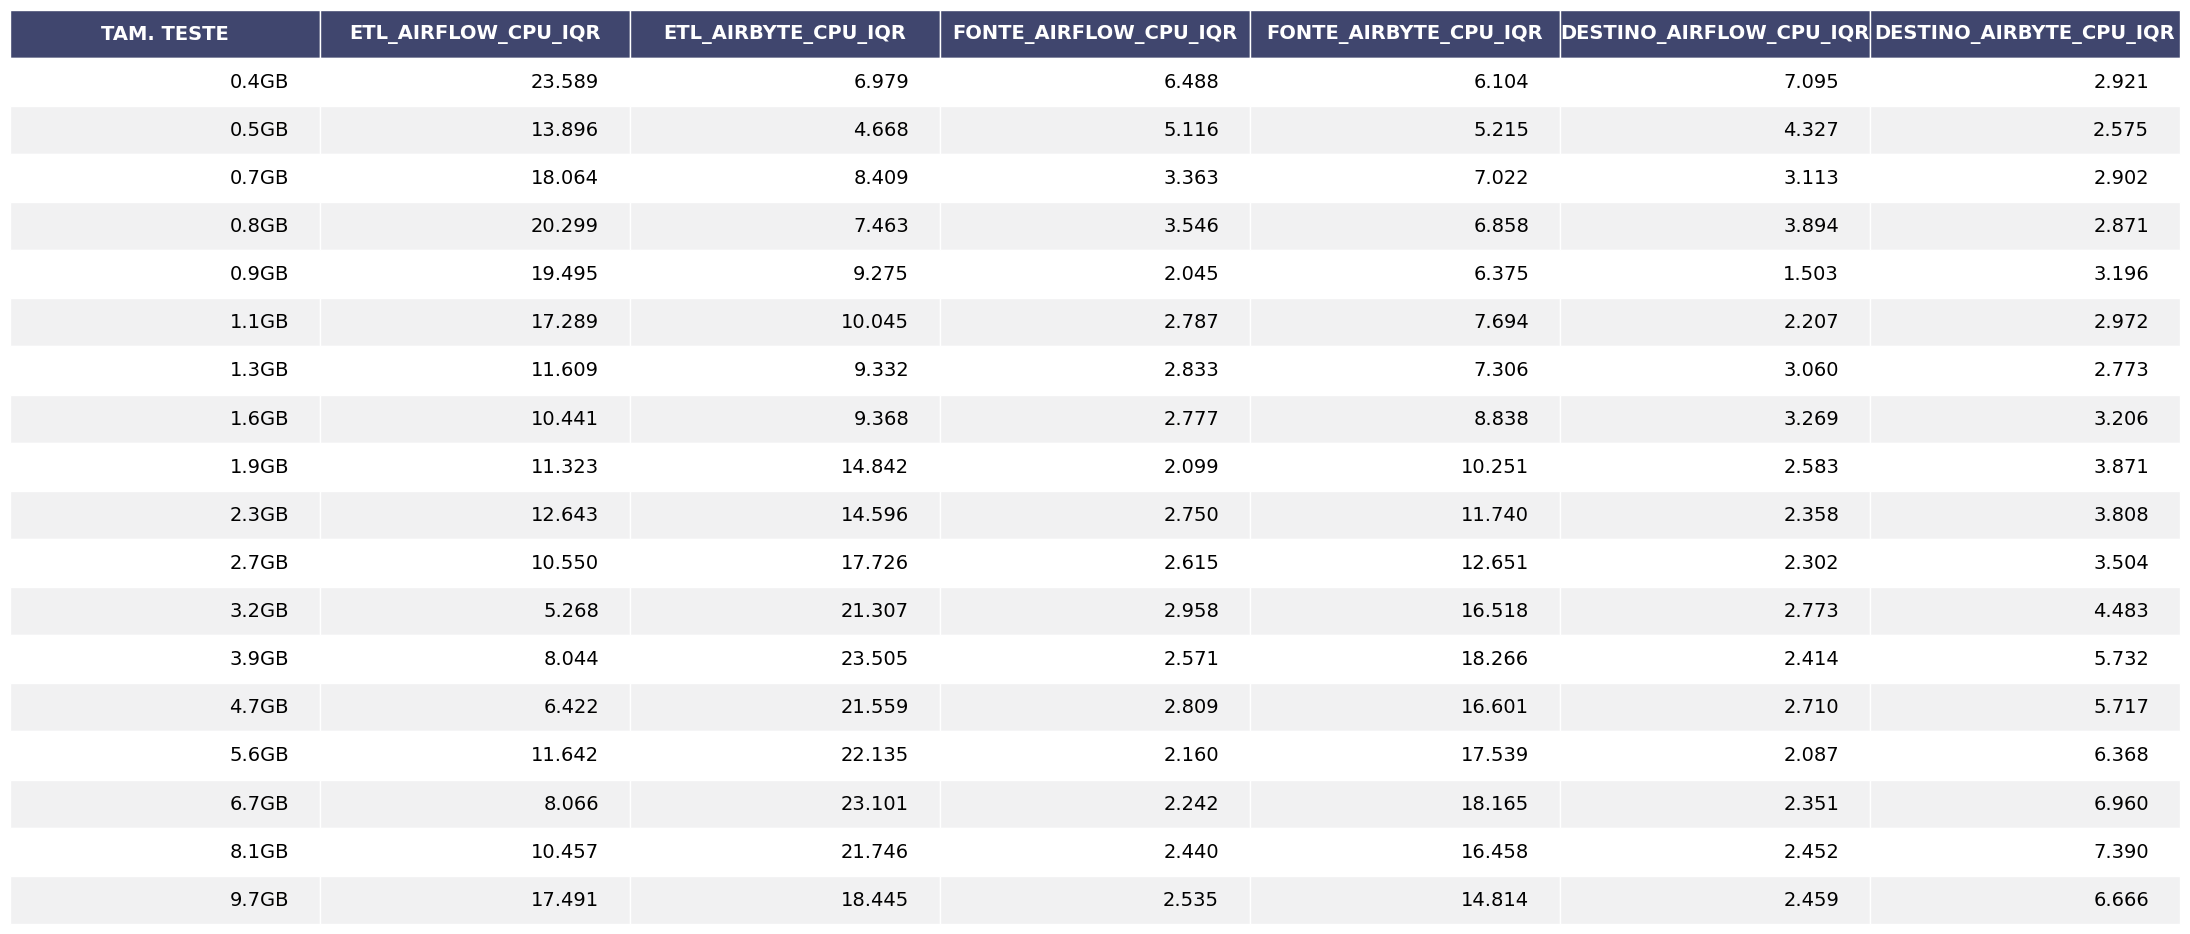

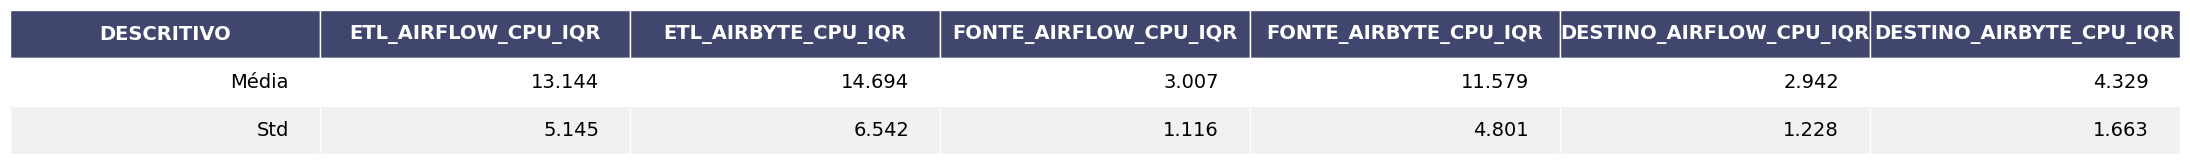

In [14]:
mask = (df_cpu.instance == "AIRFLOW") | (df_cpu.instance == "AIRBYTE")
airflow, airbyte = [], []
unique_list = df_cpu[mask].sf.unique().tolist()
iqr_calc = lambda x: x.quantile(0.75) - x.quantile(0.25)
# iqr_calc = lambda x: x.median()
for sf in unique_list:
    mask2 = df_cpu.sf == sf
    
    iqr = df_cpu[mask & mask2].groupby("instance").cpu_usage.apply(iqr_calc)
    airflow.append(iqr["AIRFLOW"])
    airbyte.append(iqr["AIRBYTE"])

mask = df_cpu.instance == "SOURCE"
source_airflow, source_airbyte = [], []
unique_list = df_cpu[mask].sf.unique().tolist()
for sf in unique_list:
    mask2 = df_cpu.sf == sf
    
    iqr = df_cpu[mask & mask2].groupby("framework").cpu_usage.apply(iqr_calc)
    source_airflow.append(iqr["Airflow + Spark"])
    source_airbyte.append(iqr["Airbyte"])

mask = df_cpu.instance == "TARGET"
target_airflow, target_airbyte = [], []
unique_list = df_cpu[mask].sf.unique().tolist()
for sf in unique_list:
    mask2 = df_cpu.sf == sf
    
    iqr = df_cpu[mask & mask2].groupby("framework").cpu_usage.apply(iqr_calc)
    target_airflow.append(iqr["Airflow + Spark"])
    target_airbyte.append(iqr["Airbyte"])

columns = ["LOADED_SIZE", "ETL_AIRFLOW_CPU_IQR", "ETL_AIRBYTE_CPU_IQR", "FONTE_AIRFLOW_CPU_IQR", "FONTE_AIRBYTE_CPU_IQR", "DESTINO_AIRFLOW_CPU_IQR", "DESTINO_AIRBYTE_CPU_IQR"]
df_stats = pd.DataFrame(data=zip(x_tick_labels, airflow, airbyte, source_airflow, source_airbyte, target_airflow, target_airbyte), columns=columns)
df_stats.set_index("LOADED_SIZE", inplace=True)
display(df_stats)

df_stats2 = pd.DataFrame(columns=columns)
df_stats2.set_index("LOADED_SIZE", inplace=True)
df_stats2.loc["Média", :] = df_stats.mean()
df_stats2.loc["Std", :] = df_stats.std()
# df_stats2.rename(columns={ ii: ii.replace("_IQR", "") for ii in columns}, inplace=True)
display(df_stats2)

render_mpl_table(df_stats.map(lambda x: f"{x:.3f}").reset_index().rename(columns={"LOADED_SIZE": "TAM. TESTE"}), header_columns=0, col_width=4)
plt.savefig("Figs/f9_cpu_prometheus_iqr.svg")
render_mpl_table(df_stats2.map(lambda x: f"{x:.3f}").reset_index().rename(columns={"LOADED_SIZE": "DESCRITIVO"}), header_columns=0, col_width=4)
plt.savefig("Figs/f10_cpu_prometheus_stats.svg")

,ETL,FONTE,DESTINO
0,"t(17) = -15.036, p-value = 0.000","t(17) = -7.869, p-value = 0.000","t(17) = 2.453, p-value = 0.025"


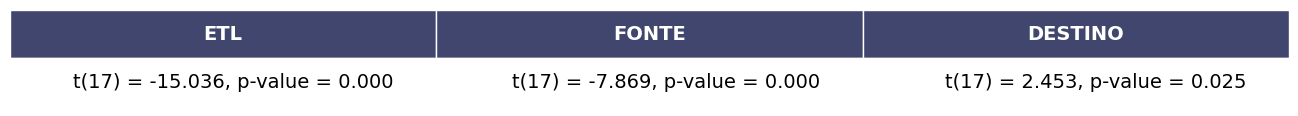

In [13]:
def ttest_string(v1, v2):
    # This is a test for the null hypothesis that two related or repeated samples have identical average (expected) values.
    result = stats.ttest_rel(v1, v2)
    
    return f"t({result.df}) = {result.statistic:.3f}, p-value = {result.pvalue:.3f}"

def cohend(d1, d2):
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    # calculate the pooled standard deviation
    s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = np.mean(d1), np.mean(d2)
    # calculate the effect size
    return (u1 - u2) / s


df_stats3 = pd.DataFrame(columns=["ETL", "FONTE", "DESTINO"])
df_stats3.loc[0,:] = [ttest_string(df_stats.ETL_AIRFLOW_CPU_IQR, df_stats.ETL_AIRBYTE_CPU_IQR),
                      ttest_string(df_stats.FONTE_AIRFLOW_CPU_IQR, df_stats.FONTE_AIRBYTE_CPU_IQR),
                      ttest_string(df_stats.DESTINO_AIRFLOW_CPU_IQR, df_stats.DESTINO_AIRBYTE_CPU_IQR)]


render_mpl_table(df_stats3, header_columns=0, col_width=5.5)
df_stats3

,ETL_AIRFLOW_RAM_IQR,ETL_AIRBYTE_RAM_IQR,FONTE_AIRFLOW_RAM_IQR,FONTE_AIRBYTE_RAM_IQR,DESTINO_AIRFLOW_RAM_IQR,DESTINO_AIRBYTE_RAM_IQR
LOADED_SIZE,,,,,,
0.4GB,1.232161,1.048603,0.001570,0.000896,0.001293,0.029930
0.5GB,0.518490,2.000347,0.001083,0.000885,0.010767,0.029263
0.7GB,0.898739,1.331131,0.001299,0.001858,0.013733,0.040115
0.8GB,2.336330,1.900211,0.001766,0.001129,0.015694,0.048696
0.9GB,1.849041,0.805107,0.001270,0.001217,0.017477,0.052490
1.1GB,1.106758,0.962059,0.001789,0.001122,0.019447,0.057255
1.3GB,1.746658,1.252342,0.001932,0.001259,0.025768,0.075752
1.6GB,2.345959,7.362499,0.001926,0.000919,0.030544,0.089268
1.9GB,1.559395,2.091072,0.001209,0.001452,0.033110,0.104263


,ETL_AIRFLOW_RAM_IQR,ETL_AIRBYTE_RAM_IQR,FONTE_AIRFLOW_RAM_IQR,FONTE_AIRBYTE_RAM_IQR,DESTINO_AIRFLOW_RAM_IQR,DESTINO_AIRBYTE_RAM_IQR
LOADED_SIZE,,,,,,
Média,2.747676,5.0992,0.006242,0.040009,0.042331,0.063216
Std,1.79972,3.962,0.012014,0.061615,0.027461,0.029313


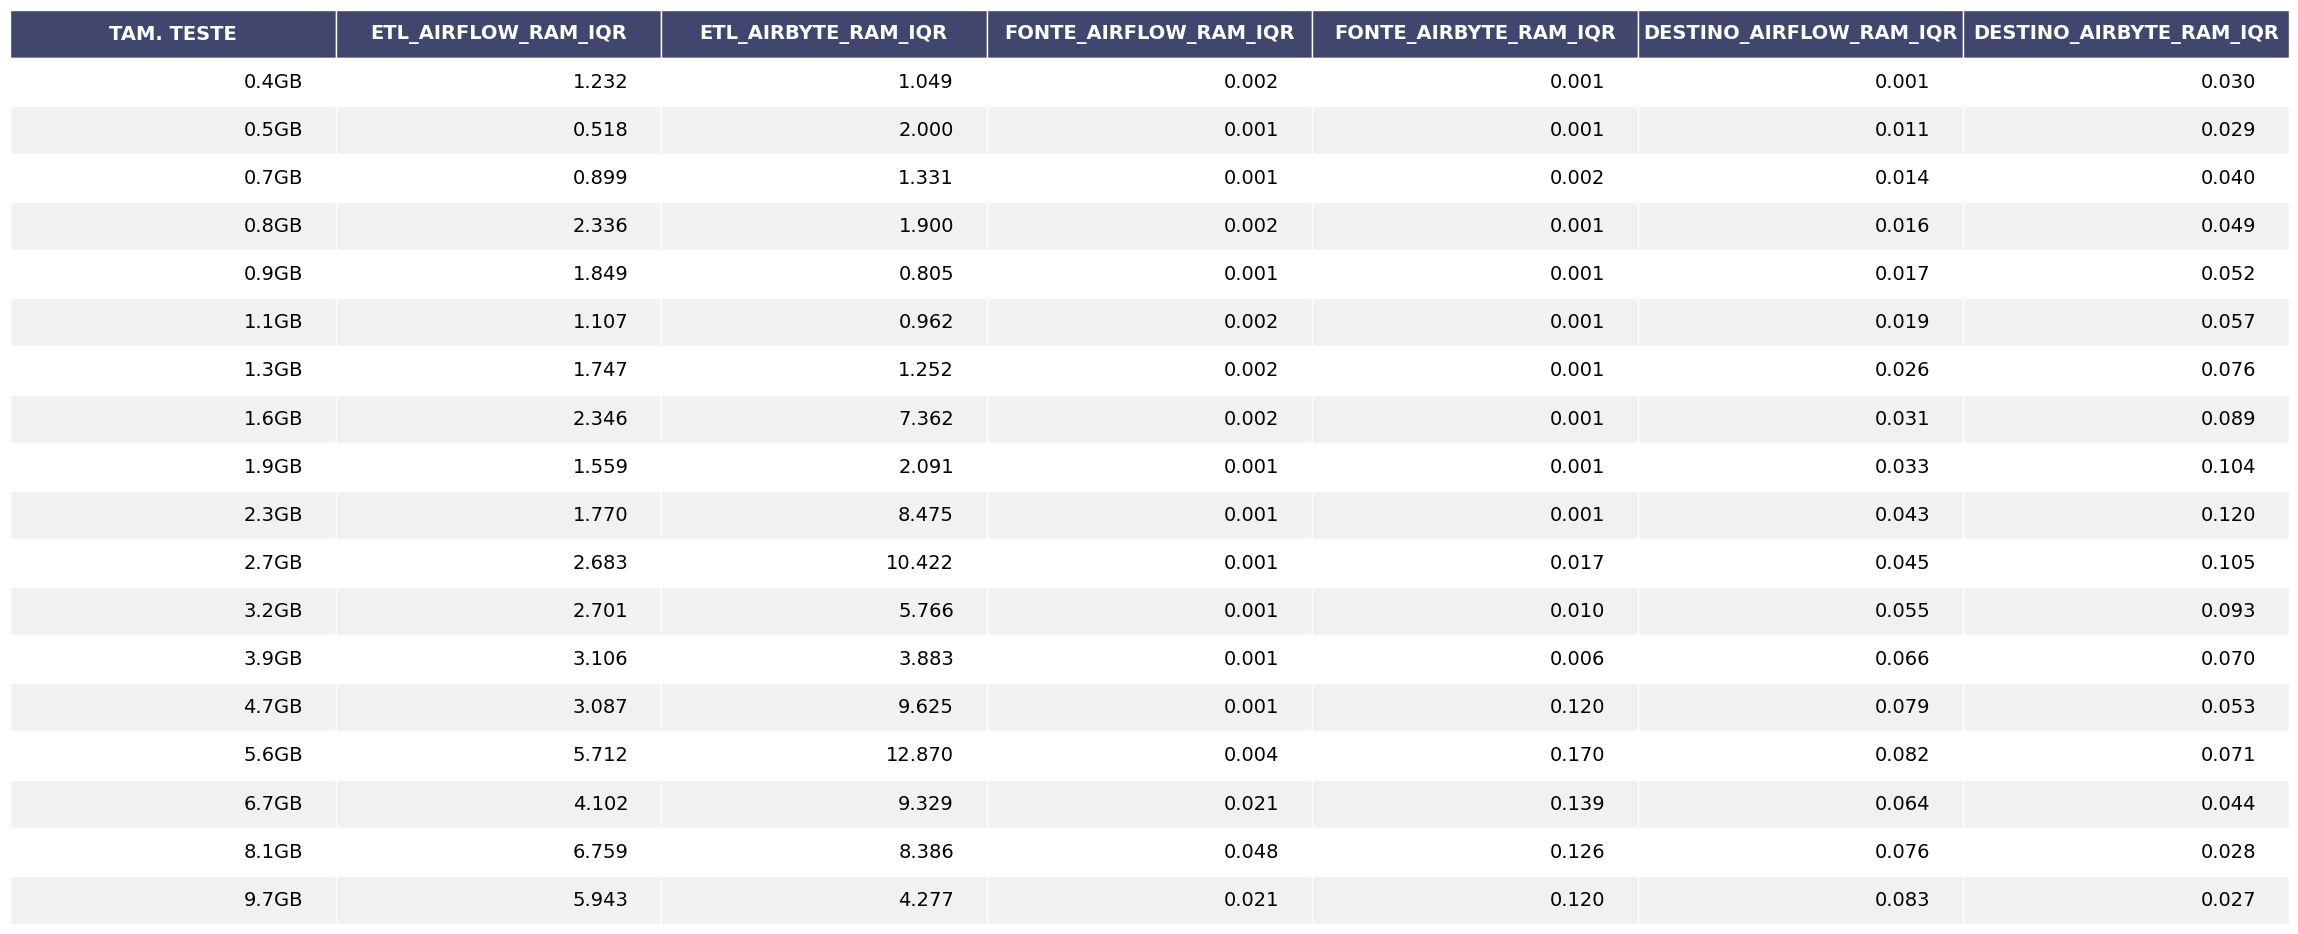

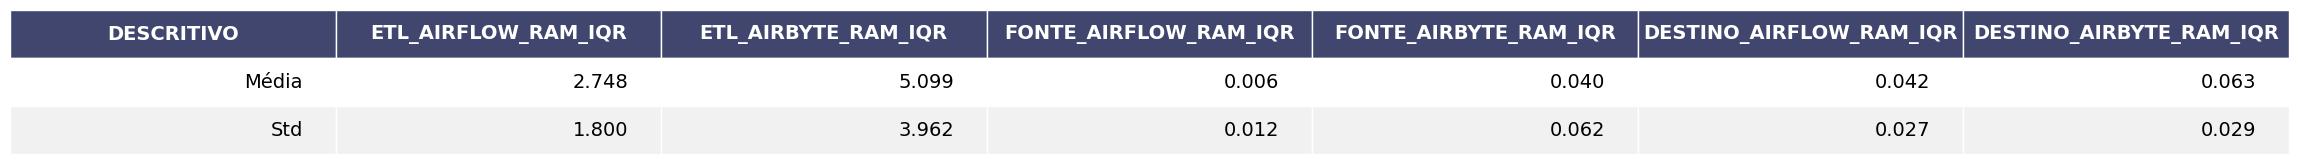

In [231]:
mask = (df_memory.instance == "AIRFLOW") | (df_memory.instance == "AIRBYTE")
airflow, airbyte = [], []
unique_list = df_memory[mask].sf.unique().tolist()
iqr_calc = lambda x: x.quantile(0.75) - x.quantile(0.25)
# iqr_calc = lambda x: x.median()
for sf in unique_list:
    mask2 = df_memory.sf == sf
    
    iqr = df_memory[mask & mask2].groupby("instance").memory_usage.apply(iqr_calc)
    airflow.append(iqr["AIRFLOW"])
    airbyte.append(iqr["AIRBYTE"])

mask = df_memory.instance == "SOURCE"
source_airflow, source_airbyte = [], []
unique_list = df_memory[mask].sf.unique().tolist()
for sf in unique_list:
    mask2 = df_memory.sf == sf
    
    iqr = df_memory[mask & mask2].groupby("framework").memory_usage.apply(iqr_calc)
    source_airflow.append(iqr["Airflow + Spark"])
    source_airbyte.append(iqr["Airbyte"])

mask = df_memory.instance == "TARGET"
target_airflow, target_airbyte = [], []
unique_list = df_memory[mask].sf.unique().tolist()
for sf in unique_list:
    mask2 = df_memory.sf == sf
    
    iqr = df_memory[mask & mask2].groupby("framework").memory_usage.apply(iqr_calc)
    target_airflow.append(iqr["Airflow + Spark"])
    target_airbyte.append(iqr["Airbyte"])

columns = ["LOADED_SIZE", "ETL_AIRFLOW_RAM_IQR", "ETL_AIRBYTE_RAM_IQR", "FONTE_AIRFLOW_RAM_IQR", "FONTE_AIRBYTE_RAM_IQR", "DESTINO_AIRFLOW_RAM_IQR", "DESTINO_AIRBYTE_RAM_IQR"]
df_stats = pd.DataFrame(data=zip(x_tick_labels, airflow, airbyte, source_airflow, source_airbyte, target_airflow, target_airbyte), columns=columns)
df_stats.set_index("LOADED_SIZE", inplace=True)
display(df_stats)

df_stats2 = pd.DataFrame(columns=columns)
df_stats2.set_index("LOADED_SIZE", inplace=True)
df_stats2.loc["Média", :] = df_stats.mean()
df_stats2.loc["Std", :] = df_stats.std()
# df_stats2.rename(columns={ ii: ii.replace("_IQR", "") for ii in columns}, inplace=True)
display(df_stats2)
render_mpl_table(df_stats.map(lambda x: f"{x:.3f}").reset_index().rename(columns={"LOADED_SIZE": "TAM. TESTE"}), header_columns=0, col_width=4.2)
plt.savefig("Figs/f11_memory_prometheus_iqr.svg")
render_mpl_table(df_stats2.map(lambda x: f"{x:.3f}").reset_index().rename(columns={"LOADED_SIZE": "DESCRITIVO"}), header_columns=0, col_width=4.2)
plt.savefig("Figs/f12_memory_prometheus_stats.svg")

In [232]:
df_stats3 = pd.DataFrame(columns=["ETL", "FONTE", "DESTINO"])
df_stats3.loc[0,:] = [ttest_string(df_stats.ETL_AIRFLOW_RAM_IQR, df_stats.ETL_AIRBYTE_RAM_IQR),
                      ttest_string(df_stats.FONTE_AIRFLOW_RAM_IQR, df_stats.FONTE_AIRBYTE_RAM_IQR),
                      ttest_string(df_stats.DESTINO_AIRFLOW_RAM_IQR, df_stats.DESTINO_AIRBYTE_RAM_IQR)]
df_stats3

,ETL,FONTE,DESTINO
0,"t(17) = -3.142, p-value = 0.006","t(17) = -2.597, p-value = 0.019","t(17) = -2.252, p-value = 0.038"


In [244]:
for row in df_stats2:
    print(f'("{row.replace("_", "\_")}", M={df_stats2.loc['Média', row]:.3f}, STD={df_stats2.loc['Std', row]:.3f})')

("ETL\_AIRFLOW\_RAM\_IQR", M=2.748, STD=1.800)
("ETL\_AIRBYTE\_RAM\_IQR", M=5.099, STD=3.962)
("FONTE\_AIRFLOW\_RAM\_IQR", M=0.006, STD=0.012)
("FONTE\_AIRBYTE\_RAM\_IQR", M=0.040, STD=0.062)
("DESTINO\_AIRFLOW\_RAM\_IQR", M=0.042, STD=0.027)
("DESTINO\_AIRBYTE\_RAM\_IQR", M=0.063, STD=0.029)


<>:2: SyntaxWarning: invalid escape sequence '\_'
<>:2: SyntaxWarning: invalid escape sequence '\_'
C:\Users\Ivan\AppData\Local\Temp\ipykernel_9500\503926899.py:2: SyntaxWarning: invalid escape sequence '\_'
  print(f'("{row.replace("_", "\_")}", M={df_stats2.loc['Média', row]:.3f}, STD={df_stats2.loc['Std', row]:.3f})')


,LOADED_SIZE,ETL_AIRFLOW_IQR,ETL_AIRBYTE_IQR,SOURCE_AIRFLOW_IQR,SOURCE_AIRBYTE_IQR,TARGET_AIRFLOW_IQR,TARGET_AIRBYTE_IQR
0,Média,2.748,5.099,0.006,0.040,0.042,0.063
1,Std,1.800,3.962,0.012,0.062,0.027,0.029
